In [8]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn

In [9]:
%store -r cook_county_gdf_year
%store -r CC_nodeaths
cook_county_gdf = cook_county_gdf_year

In [52]:
#add in missing 58 tracts
cook_county_gdf['deaths'] = 1
cook_county_gdf = pd.concat([cook_county_gdf, CC_nodeaths], ignore_index=True)
cook_county_gdf['year'].fillna(9999, inplace=True)

In [53]:
cook_county_gdf['GEOID'].nunique() #now we have all census tracts

1332

In [54]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

gdf_annual = cook_county_gdf.groupby(['GEOID', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

In [55]:
gdf_annual

,GEOID,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17031010100,2014.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,POINT (-87.66632 42.02212)
1,17031010100,2015.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,POINT (-87.67202 42.01989)
2,17031010100,2016.0,3,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,POINT (-87.67142 42.02143)
3,17031010100,2017.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,POINT (-87.66805 42.02216)
4,17031010100,2019.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,POINT (-87.66739 42.02232)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,17031980000,2022.0,3,17,031,980000,9800,Census Tract 9800,G5020,S,19890200,92402,+41.9794191,-087.9024376,POINT (-87.90647 41.97684)
5818,17031980000,2023.0,4,17,031,980000,9800,Census Tract 9800,G5020,S,19890200,92402,+41.9794191,-087.9024376,POINT (-87.90398 41.97572)
5819,17031980100,2018.0,1,17,031,980100,9801,Census Tract 9801,G5020,S,2981781,0,+41.7859813,-087.7509001,POINT (-87.74137 41.78952)
5820,17031980100,2022.0,1,17,031,980100,9801,Census Tract 9801,G5020,S,2981781,0,+41.7859813,-087.7509001,POINT (-87.73804 41.78672)


In [56]:
gdf_annual['GEOID'].nunique() 

1332

In [57]:
(gdf_annual['year'] == 9999).sum()

58

### Making DF square - one year for each tract



In [58]:
gdf_annual.loc[gdf_annual['year'] == 9999, 'deaths'] = 0

# Replace 9999 with 2014 in the 'year' column
gdf_annual['year'].replace(9999, 2014, inplace=True)

In [59]:
##uses nested for loops - not exactly the most efficient 

years = range(2014, 2024)
updated_rows = []

for tract in gdf_annual['GEOID'].unique():
    existing_years = set(gdf_annual[gdf_annual['GEOID'] == tract]['year'])
    missing_years = set(years) - existing_years
    
    for year in missing_years:
        new_row = {'GEOID': tract, 
                   'year': year, 
                   'deaths': 0}
        
        # duplicate values
        above_rows = gdf_annual[(gdf_annual['GEOID'] == tract) & (gdf_annual['year'] < year)]

        if len(above_rows) > 0:
            above_rows = above_rows.sort_values('year')
            above_row = above_rows.tail(1) 
            for col in columns_to_keep:
                new_row[col] = above_row[col].values[0]
        
        updated_rows.append(new_row)

gdf_annual = pd.concat([gdf_annual, pd.DataFrame(updated_rows)], ignore_index=True)

In [60]:
gdf_annual.shape #was 13320, 15

(13320, 15)

In [62]:
gdf_annual

,GEOID,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17031010100,2014.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.6663230817571 42.02212131250278)
1,17031010100,2015.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.6720215858155 42.01988747796546)
2,17031010100,2016.0,3,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.6714206343906 42.021433935507915)
3,17031010100,2017.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.66804697796988 42.02215989618944)
4,17031010100,2019.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.66738942107895 42.02231773441726)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13315,17031990000,2020.0,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."
13316,17031990000,2021.0,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."
13317,17031990000,2022.0,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."
13318,17031990000,2023.0,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."


## Tables & Graphs

In [63]:
gdf_annual['year'] = pd.to_datetime(gdf_annual['year'].astype(int).astype(str), format='%Y').dt.year

In [64]:
gdf_annual

,GEOID,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17031010100,2014,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.6663230817571 42.02212131250278)
1,17031010100,2015,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.6720215858155 42.01988747796546)
2,17031010100,2016,3,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.6714206343906 42.021433935507915)
3,17031010100,2017,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.66804697796988 42.02215989618944)
4,17031010100,2019,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,POINT (-87.66738942107895 42.02231773441726)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13315,17031990000,2020,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."
13316,17031990000,2021,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."
13317,17031990000,2022,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."
13318,17031990000,2023,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.741562 42.153226, -87.721762 42...."


In [65]:
sparsity_df = pd.DataFrame(columns=['year', 'Total Deaths', 'Sparsity Rate'])

years = range(2014, 2023)
for year in years:
    year_df = gdf_annual[gdf_annual['year'] == year]
    zero_deaths_count = year_df[year_df['deaths'] == 0].shape[0]
    total_count = year_df.shape[0]
    sparsity_rate = (zero_deaths_count / total_count) * 100
    total_deaths = year_df['deaths'].sum()
    sparsity_df = pd.concat([sparsity_df, pd.DataFrame({'year': [year], 'Total Deaths': [total_deaths], 'Sparsity Rate': [sparsity_rate]})], ignore_index=True)


raw_sparsity = sparsity_df['Sparsity Rate']
sparsity_df['Sparsity Rate'] = sparsity_df['Sparsity Rate'].round(3).astype(str) + '%'
print(sparsity_df)

   year Total Deaths Sparsity Rate
0  2014          209       86.036%
1  2015          616       67.342%
2  2016         1029       53.754%
3  2017         1109       53.303%
4  2018         1078       54.429%
5  2019         1210       52.102%
6  2020         1687       43.619%
7  2021         1790       43.168%
8  2022         1849       43.018%


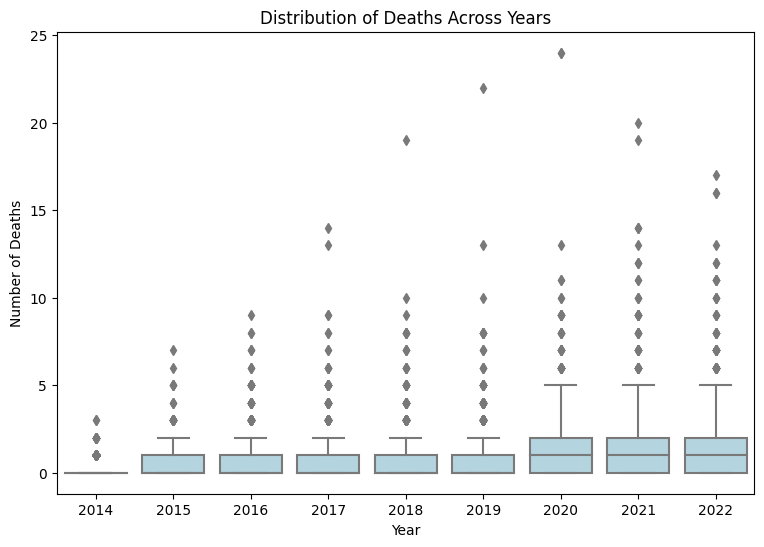

In [66]:
plt.figure(figsize=(9, 6))
df_no23 = gdf_annual[gdf_annual['year'] != 2023]
sns.boxplot(x='year', y='deaths', data=df_no23, color='lightblue')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Distribution of Deaths Across Years')

plt.show()


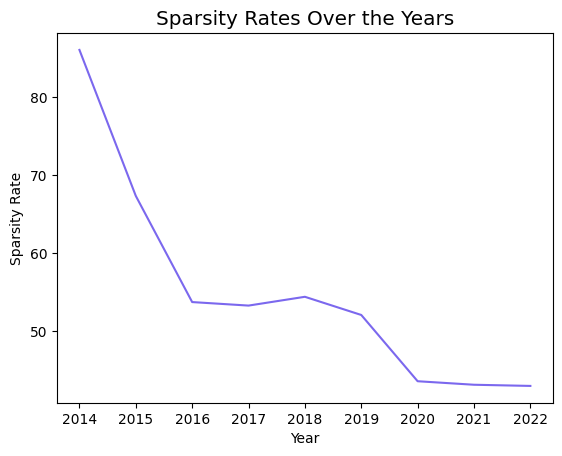

In [67]:
plt.plot(range(2014, 2023), raw_sparsity, color='mediumslateblue')

font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)


plt.xlabel('Year')
plt.ylabel('Sparsity Rate')
plt.title('Sparsity Rates Over the Years')
plt.grid(False)

plt.show()